In [1]:
%run -i model.ipynb

CPU times: user 956 ms, sys: 124 ms, total: 1.08 s
Wall time: 927 ms


100%|██████████| 100/100 [00:00<00:00, 1029.63it/s]


## Recovering conditional density with FFJORD

# All needed imports

In [2]:
device = torch.device('cuda:0')

In [3]:
import sys
import torch
import torch.optim as optim

sys.path.append('./ffjord/')
import ffjord.lib.utils as utils
from ffjord.lib.visualize_flow import visualize_transform
import ffjord.lib.layers.odefunc as odefunc
from ffjord.train_misc import standard_normal_logprob
from ffjord.train_misc import count_nfe, count_parameters, count_total_time
from ffjord.train_misc import add_spectral_norm, spectral_norm_power_iteration
from ffjord.train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from ffjord.train_misc import build_model_tabular
import lib.layers as layers

In [4]:
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']

print(odefunc.NONLINEARITIES)

{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


In [5]:
def set_cnf_options(model, solver, rademacher, residual, atol=1e-5, rtol=1e-5):

    def _set(module):
        if isinstance(module, layers.CNF):
            # Set training settings
            module.solver = solver
            module.atol = atol
            module.rtol = rtol

            # If using fixed-grid adams, restrict order to not be too high.
            if solver in ['fixed_adams', 'explicit_adams']:
                module.solver_options['max_order'] = 4

        if isinstance(module, layers.ODEfunc):
            module.rademacher = rademacher
            module.residual = residual

    model.apply(_set)
    
# layer_type - ["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]
def build_model_tabular(dims=2,
                        layer_type='concatsquash', 
                        nonlinearity='relu', 
                        residual=False, 
                        rademacher=False,
                        train_T=True,
                        solver='dopri5',
                        time_length=0.1,
                        divergence_fn='brute_force', # ["brute_force", "approximate"]
                        hidden_dims=(32, 32), 
                        num_blocks=1, batch_norm=False, 
                        bn_lag=0, regularization_fns=None):


    def build_cnf():
        diffeq = layers.ODEnet(
            hidden_dims=hidden_dims,
            input_shape=(dims,),
            strides=None,
            conv=False,
            layer_type=layer_type,
            nonlinearity=nonlinearity,
        )
        odefunc = layers.ODEfunc(
            diffeq=diffeq,
            divergence_fn=divergence_fn,
            residual=residual,
            rademacher=rademacher,
        )
        cnf = layers.CNF(
            odefunc=odefunc,
            T=time_length,
            train_T=train_T,
            regularization_fns=regularization_fns,
            solver=solver,
        )
        return cnf

    chain = [build_cnf() for _ in range(num_blocks)]
    if batch_norm:
        bn_layers = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag) for _ in range(num_blocks)]
        bn_chain = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag)]
        for a, b in zip(chain, bn_layers):
            bn_chain.append(a)
            bn_chain.append(b)
        chain = bn_chain
    model = layers.SequentialFlow(chain)

    set_cnf_options(model, solver, rademacher, residual)

    return model


In [6]:
import ffjord.lib.layers.wrappers.cnf_regularization as reg_lib
import six

REGULARIZATION_FNS = {
    "l1int": reg_lib.l1_regularzation_fn,
    "l2int": reg_lib.l2_regularzation_fn,
    "dl2int": reg_lib.directional_l2_regularization_fn,
    "JFrobint": reg_lib.jacobian_frobenius_regularization_fn,
    "JdiagFrobint": reg_lib.jacobian_diag_frobenius_regularization_fn,
    "JoffdiagFrobint": reg_lib.jacobian_offdiag_frobenius_regularization_fn,
}

def create_regularization_fns(regs={'l1int': 1., 'JFrobint': 1.}):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if arg_key in regs:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(regs[arg_key])

    regularization_fns = tuple(regularization_fns)
    regularization_coeffs = tuple(regularization_coeffs)
    return regularization_fns, regularization_coeffs


def get_regularization(model, regularization_coeffs):
    if len(regularization_coeffs) == 0:
        return None

    acc_reg_states = tuple([0.] * len(regularization_coeffs))
    for module in model.modules():
        if isinstance(module, layers.CNF):
            acc_reg_states = tuple(acc + reg for acc, reg in zip(acc_reg_states, module.get_regularization_states()))
    return acc_reg_states

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

In [9]:
import math

def standard_normal_logprob(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([.1, 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def compute_loss(model, data, batch_size=None):
    # load data
    #x = sample_data(data, batch_size=batch_size)
    #x = torch.from_numpy(x).float().to(device)
    # zero = torch.stack([torch.zeros(data.shape[0]).to(data.device), data[:, 1], data[:, 2]], dim=1).float()
    zero = torch.zeros(data.shape[0], 1).to(data.device)
    # print(zero.shape)
    # transform to z
    #zero[:, 2] = data[:, 2].detach()
    z, delta_logp = model(data, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z, data).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

# Sampling train dataset

In [10]:
n_samples = 1000
y_sampler = YModel()
mu_range = (-30, 30)
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(n_samples)) + mu_range[1]).to(device)
xs = y_sampler.x_dist.sample([n_samples]).to(device)
y_sampler.make_condition_sample({'mu': mus, 'X':xs})
data = y_sampler.condition_sample().detach().to(device)
data = torch.stack([data, mus, xs]).detach().t().to(device)

# Optimization is not very stable so should be optimized...

# Defining FFJORD model

In [11]:
regularization_fns = None
#regularization_fns, regularization_coeffs = create_regularization_fns()
model = build_model_tabular(dims=3, 
                            num_blocks=1, 
                            hidden_dims=(32, 32), bn_lag=0.1,
                            regularization_fns=regularization_fns).to(device)

In [12]:
from torch.nn.utils import clip_grad_norm
from tqdm import tqdm

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [14]:
model.train();
for i in tqdm(range(20)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 4:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    
    print(loss_meter.avg, nfe_total)

  5%|▌         | 1/20 [00:00<00:08,  2.22it/s]

1606.3680419921875 35.0


 10%|█         | 2/20 [00:00<00:07,  2.46it/s]

1587.3999633789062 35.0


 15%|█▌        | 3/20 [00:01<00:06,  2.44it/s]

1517.5281677246094 47.0


 20%|██        | 4/20 [00:01<00:06,  2.29it/s]

1349.5301361083984 59.0


 25%|██▌       | 5/20 [00:02<00:07,  2.12it/s]

1037.9567184448242 65.0


 30%|███       | 6/20 [00:03<00:08,  1.66it/s]

681.4852409362793 113.0


 35%|███▌      | 7/20 [00:05<00:12,  1.02it/s]

497.0599422454834 245.0


 40%|████      | 8/20 [00:07<00:15,  1.30s/it]

358.5119276046753 269.0


 45%|████▌     | 9/20 [00:09<00:17,  1.61s/it]

260.56482458114624 305.0


 50%|█████     | 10/20 [00:11<00:18,  1.81s/it]

184.82671236991882 305.0


 55%|█████▌    | 11/20 [00:14<00:17,  1.97s/it]

130.56228578090668 305.0


 60%|██████    | 12/20 [00:16<00:16,  2.04s/it]

96.94057434797287 293.0


 65%|██████▌   | 13/20 [00:18<00:15,  2.21s/it]

77.16909393668175 329.0


 70%|███████   | 14/20 [00:21<00:14,  2.34s/it]

64.24374763667583 347.0


 75%|███████▌  | 15/20 [00:24<00:12,  2.53s/it]

54.16480823606253 389.0


 80%|████████  | 16/20 [00:27<00:11,  2.77s/it]

46.081713657826185 431.0


 85%|████████▌ | 17/20 [00:31<00:09,  3.10s/it]

40.33528851531446 503.0


 90%|█████████ | 18/20 [00:35<00:06,  3.34s/it]

36.79380964767188 497.0


 95%|█████████▌| 19/20 [00:39<00:03,  3.67s/it]

34.71578109031543 569.0


100%|██████████| 20/20 [00:44<00:00,  3.99s/it]

33.269697605399415 617.0


In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [16]:
model.train();
for i in tqdm(range(50)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 4:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    
    print(loss_meter.avg, nfe_total)

  2%|▏         | 1/50 [00:05<04:13,  5.17s/it]

30.449922561645508 665.0


  4%|▍         | 2/50 [00:10<04:05,  5.11s/it]

27.006677627563477 635.0


  6%|▌         | 3/50 [00:14<03:56,  5.03s/it]

22.783102989196777 623.0


  8%|▊         | 4/50 [00:19<03:48,  4.97s/it]

19.00465965270996 623.0


 10%|█         | 5/50 [00:24<03:41,  4.92s/it]

16.150805473327637 617.0


 12%|█▏        | 6/50 [00:29<03:30,  4.78s/it]

14.31530237197876 581.0


 14%|█▍        | 7/50 [00:33<03:20,  4.66s/it]

13.36705470085144 569.0


 16%|█▌        | 8/50 [00:38<03:15,  4.65s/it]

13.009490847587585 587.0


 18%|█▊        | 9/50 [00:42<03:09,  4.62s/it]

12.872600495815277 581.0


 20%|██        | 10/50 [00:47<03:03,  4.59s/it]

12.64725348353386 581.0


 22%|██▏       | 11/50 [00:51<02:59,  4.61s/it]

12.172514662146568 599.0


 24%|██▍       | 12/50 [00:56<02:54,  4.60s/it]

11.441805236041546 587.0


 26%|██▌       | 13/50 [01:01<02:50,  4.61s/it]

10.553577121347189 593.0


 28%|██▊       | 14/50 [01:05<02:47,  4.66s/it]

9.646685926243663 611.0


 30%|███       | 15/50 [01:10<02:41,  4.62s/it]

8.844309492968023 581.0


 32%|███▏      | 16/50 [01:15<02:37,  4.65s/it]

8.220926127862185 599.0


 34%|███▍      | 17/50 [01:19<02:35,  4.70s/it]

7.795359771465883 617.0


 36%|███▌      | 18/50 [01:24<02:31,  4.72s/it]

7.5398803557036445 611.0


 38%|███▊      | 19/50 [01:29<02:27,  4.76s/it]

7.398960630351212 611.0


 40%|████      | 20/50 [01:34<02:25,  4.83s/it]

7.307501574483467 641.0


 42%|████▏     | 21/50 [01:39<02:21,  4.87s/it]

7.205478559000767 635.0


 44%|████▍     | 22/50 [01:44<02:15,  4.85s/it]

7.050856535664934 617.0


 46%|████▌     | 23/50 [01:48<02:09,  4.81s/it]

6.8293678487498255 605.0


 48%|████▊     | 24/50 [01:53<02:04,  4.79s/it]

6.556135760007237 617.0


 50%|█████     | 25/50 [01:58<01:58,  4.75s/it]

6.267026954024004 599.0


 52%|█████▏    | 26/50 [02:02<01:51,  4.64s/it]

6.002416875525796 563.0


 54%|█████▍    | 27/50 [02:07<01:46,  4.63s/it]

5.792467249713582 593.0


 56%|█████▌    | 28/50 [02:11<01:41,  4.63s/it]

5.650036878030619 593.0


 58%|█████▊    | 29/50 [02:16<01:36,  4.60s/it]

5.570730957707326 581.0


 60%|██████    | 30/50 [02:21<01:33,  4.65s/it]

5.536361591677149 605.0


 62%|██████▏   | 31/50 [02:26<01:28,  4.67s/it]

5.52015108697627 605.0


 64%|██████▍   | 32/50 [02:30<01:23,  4.64s/it]

5.494723532761206 581.0


 66%|██████▌   | 33/50 [02:35<01:18,  4.62s/it]

5.441862689537341 599.0


 68%|██████▊   | 34/50 [02:39<01:14,  4.63s/it]

5.359361463329462 587.0


 70%|███████   | 35/50 [02:44<01:09,  4.66s/it]

5.260143664251401 605.0


 72%|███████▏  | 36/50 [02:49<01:05,  4.65s/it]

5.163938952868499 593.0


 74%|███████▍  | 37/50 [02:53<01:00,  4.69s/it]

5.08780477115776 611.0


 76%|███████▌  | 38/50 [02:58<00:55,  4.60s/it]

5.040123212681541 563.0


 78%|███████▊  | 39/50 [03:03<00:51,  4.65s/it]

5.019936436586742 611.0


 80%|████████  | 40/50 [03:07<00:46,  4.68s/it]

5.018968758073035 623.0


 82%|████████▏ | 41/50 [03:12<00:41,  4.65s/it]

5.024807302696796 599.0


 84%|████████▍ | 42/50 [03:17<00:37,  4.68s/it]

5.025057479015635 611.0


 86%|████████▌ | 43/50 [03:21<00:32,  4.71s/it]

5.012285314138555 623.0


 88%|████████▊ | 44/50 [03:26<00:28,  4.71s/it]

4.986309807566714 605.0


 90%|█████████ | 45/50 [03:31<00:23,  4.71s/it]

4.9535509551902175 605.0


 92%|█████████▏| 46/50 [03:36<00:18,  4.69s/it]

4.922611544794815 593.0


 94%|█████████▍| 47/50 [03:40<00:14,  4.69s/it]

4.9002138725255815 611.0


 96%|█████████▌| 48/50 [03:45<00:09,  4.66s/it]

4.88875349120969 605.0


 98%|█████████▊| 49/50 [03:49<00:04,  4.66s/it]

4.886614599608752 605.0


100%|██████████| 50/50 [03:54<00:00,  4.62s/it]

4.889247079085992 593.0


In [17]:
model.eval()

SequentialFlow(
  (chain): ModuleList(
    (0): CNF(
      (odefunc): ODEfunc(
        (diffeq): ODEnet(
          (layers): ModuleList(
            (0): ConcatSquashLinear(
              (_layer): Linear(in_features=3, out_features=32, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=32, bias=True)
            )
            (1): ConcatSquashLinear(
              (_layer): Linear(in_features=32, out_features=32, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=32, bias=True)
            )
            (2): ConcatSquashLinear(
              (_layer): Linear(in_features=32, out_features=3, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=3, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=3, bias=True)
            )
          )


In [18]:
sample_fn, density_fn = get_transforms(model)

# Test on mu outside of training domain

It was trained on $\mu \in [ -30: 30]$ and evaluated on $\mu \in [ -22: 60]$

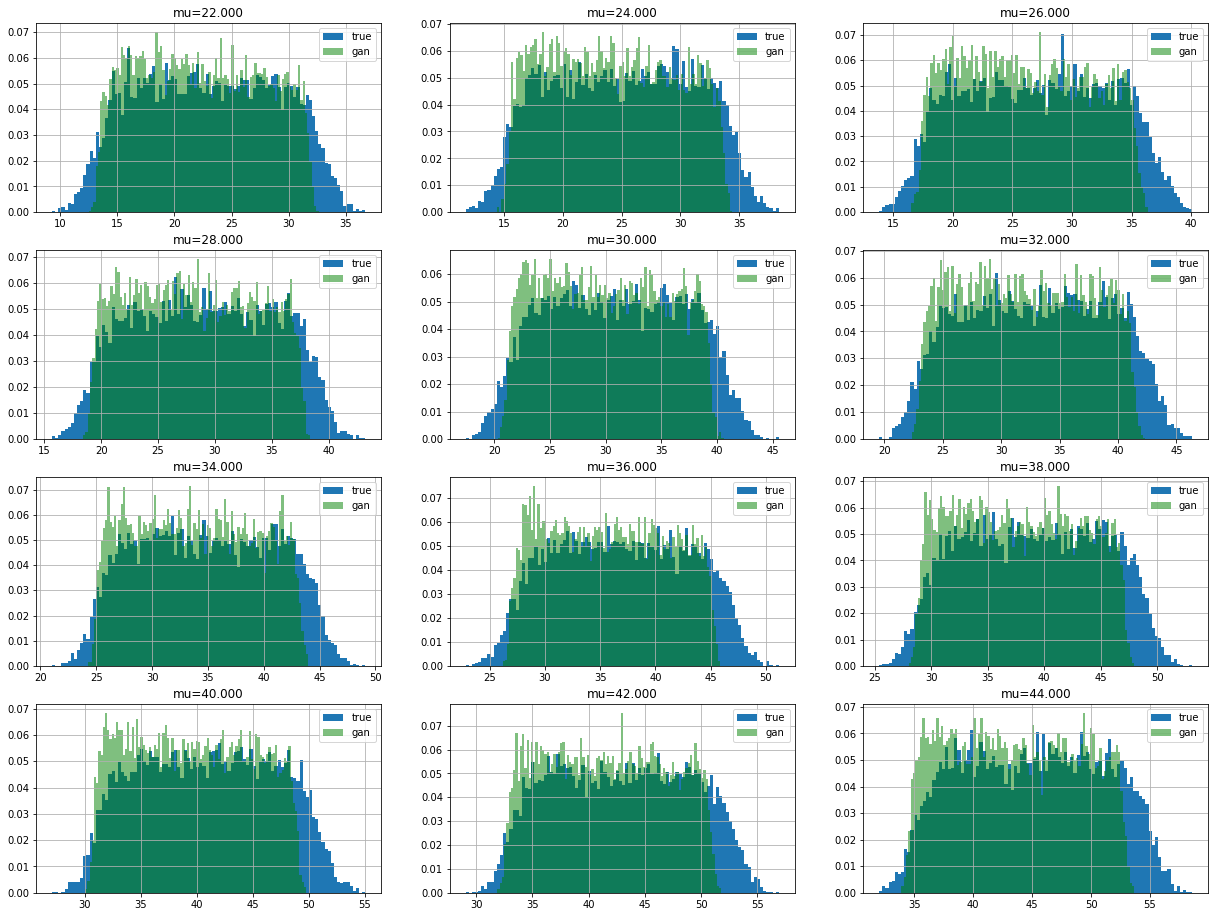

In [19]:
plt.figure(figsize=(21,16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        
        data_ref = torch.stack([0.1 * torch.randn(len(input_mu)).to(device), 
                                input_mu, input_x], dim=1).float()
        sampled = sample_fn(data_ref)
        
        
        plt.hist(data, bins=100, normed=True, label='true');
        plt.hist(sampled[:, 0].detach().cpu().numpy(),
             bins=100, color='g', density=True, alpha=0.5, label='gan');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Density estimation

In [24]:
from scipy.signal import savgol_filter
def standard_normal_logprob_for_sampling(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def proba_fn(data_ref, density_fn):
    zero_ref = torch.stack([torch.zeros(len(data_ref)).to(device), 
                            data_ref[:, 1],
                            data_ref[:, 2]], dim=1).float()
    z, delta_logp = density_fn(data_ref, zero_ref)
    logpz = standard_normal_logprob_for_sampling(z, data_ref)
    logpx = logpz - delta_logp
    
    yhat = savgol_filter(logpx.sum(dim=1).detach().cpu().numpy(), 501, 3)
    proba = exp_normalize(yhat)
    return proba

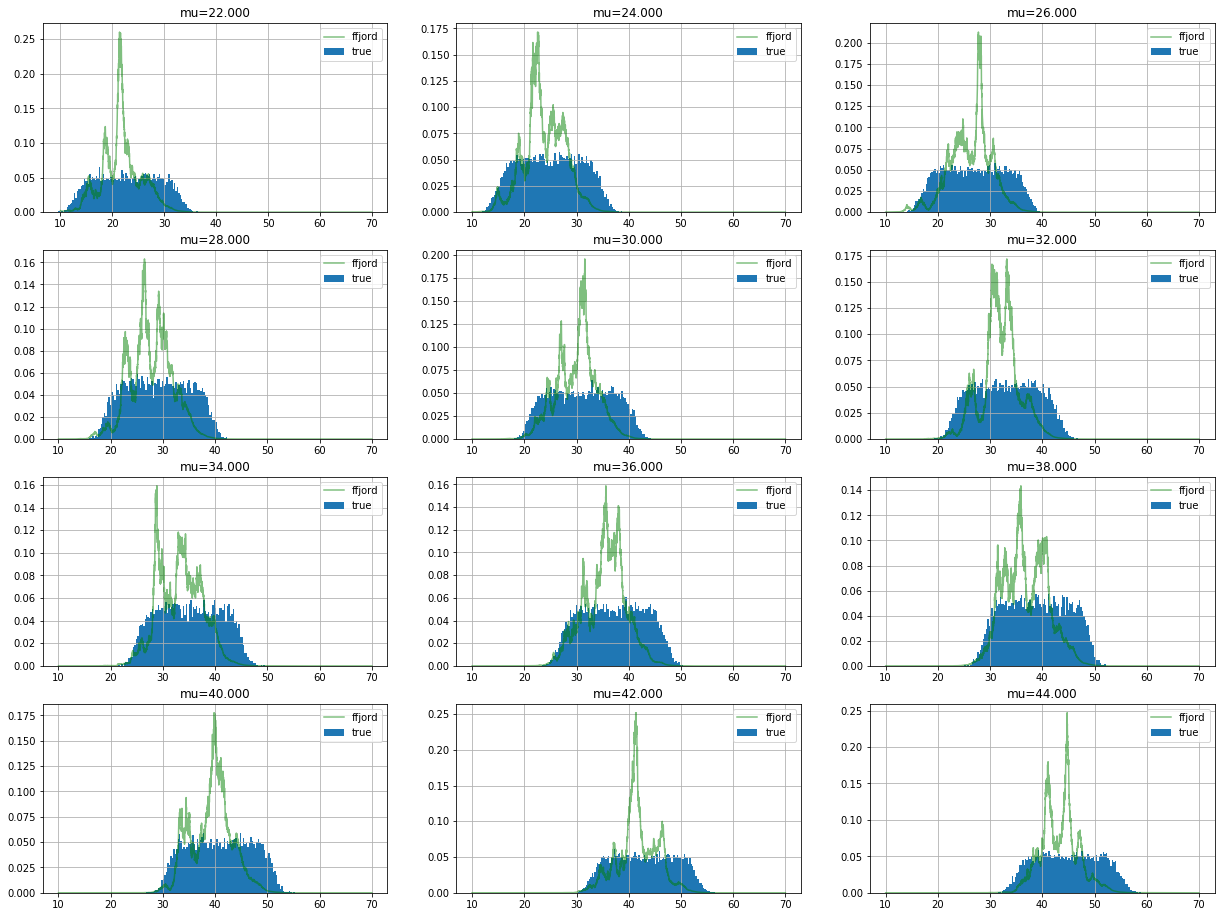

In [21]:
plt.figure(figsize=(21, 16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4, 3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        ref = torch.linspace(10, 70, len(input_mu)).float().to(device)
        data_ref = torch.stack([ref, input_mu, input_x], dim=1).float()
        proba = proba_fn(data_ref, density_fn)
        plt.hist(data, bins=100, normed=True, label='true');
        plt.plot(ref.detach().cpu().numpy(), proba / (ref[1] - ref[0]).item(), color='g', alpha=0.5, label='ffjord');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Test optimisation

In [26]:
lr = 0.1
sample_size = 100


mu_optim = torch.tensor(30.)
mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [ ]:
%%time
n_iter = 3000
losses = []
m_vals = []
for _iter in tqdm(range(n_iter)):    
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update    
    data_ref = torch.stack([torch.randn(len(mu_optim)).to(device), 
                            mu_optim, x], dim=1).float()
    sampled = sample_fn(data_ref)
    
    loss = R(sampled[:, 0])
    losses.append(loss.item())
    if mu_optim.grad is not None: mu_optim.grad.zero_()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())
    print(mu_optim[0].item())

  0%|          | 1/3000 [00:06<5:39:57,  6.80s/it]

29.93254280090332


  0%|          | 2/3000 [00:13<5:34:02,  6.69s/it]

29.863983154296875


  0%|          | 3/3000 [00:20<5:43:31,  6.88s/it]

29.797224044799805


  0%|          | 4/3000 [00:27<5:42:32,  6.86s/it]

29.729202270507812


  0%|          | 5/3000 [00:34<5:49:54,  7.01s/it]

29.662817001342773


  0%|          | 6/3000 [00:42<6:01:08,  7.24s/it]

29.59871482849121


  0%|          | 7/3000 [00:48<5:48:19,  6.98s/it]

29.531421661376953


  0%|          | 8/3000 [00:56<5:57:00,  7.16s/it]

29.46668243408203


  0%|          | 9/3000 [01:03<5:47:51,  6.98s/it]

29.39788055419922


  0%|          | 10/3000 [01:10<5:51:09,  7.05s/it]

29.3320255279541


  0%|          | 11/3000 [01:17<5:49:39,  7.02s/it]

29.26615333557129


  0%|          | 12/3000 [01:24<5:47:16,  6.97s/it]

29.200092315673828


  0%|          | 13/3000 [01:30<5:43:38,  6.90s/it]

29.133440017700195


  0%|          | 14/3000 [01:37<5:47:56,  6.99s/it]

29.066547393798828


  0%|          | 15/3000 [01:45<5:50:26,  7.04s/it]

28.999147415161133


  1%|          | 16/3000 [01:51<5:39:10,  6.82s/it]

28.93433952331543


  1%|          | 17/3000 [01:58<5:45:15,  6.94s/it]

28.86757469177246


  1%|          | 18/3000 [02:05<5:41:48,  6.88s/it]

28.800121307373047


  1%|          | 19/3000 [02:11<5:30:19,  6.65s/it]

28.73411750793457


  1%|          | 20/3000 [02:19<5:50:25,  7.06s/it]

28.669612884521484


  1%|          | 21/3000 [02:26<5:42:33,  6.90s/it]

28.60222625732422


  1%|          | 22/3000 [02:33<5:51:03,  7.07s/it]

28.537532806396484


  1%|          | 23/3000 [02:40<5:45:57,  6.97s/it]

28.472429275512695


  1%|          | 24/3000 [02:47<5:46:11,  6.98s/it]

28.407447814941406


  1%|          | 25/3000 [02:54<5:45:16,  6.96s/it]

28.34320640563965


  1%|          | 26/3000 [03:01<5:45:40,  6.97s/it]

28.279460906982422


  1%|          | 27/3000 [03:07<5:34:43,  6.76s/it]

28.214862823486328


  1%|          | 28/3000 [03:13<5:22:13,  6.51s/it]

28.14851188659668


  1%|          | 29/3000 [03:20<5:27:38,  6.62s/it]

28.084514617919922


  1%|          | 30/3000 [03:27<5:30:53,  6.68s/it]

28.0205078125


  1%|          | 31/3000 [03:33<5:34:09,  6.75s/it]

27.957094192504883


  1%|          | 32/3000 [03:41<5:45:43,  6.99s/it]

27.89117431640625


  1%|          | 33/3000 [03:47<5:32:08,  6.72s/it]

27.82882308959961


  1%|          | 34/3000 [03:54<5:33:39,  6.75s/it]

27.764266967773438


  1%|          | 35/3000 [04:01<5:36:13,  6.80s/it]

27.699424743652344


  1%|          | 36/3000 [04:07<5:29:07,  6.66s/it]

27.637575149536133


  1%|          | 37/3000 [04:14<5:32:25,  6.73s/it]

27.57513999938965


  1%|▏         | 38/3000 [04:21<5:36:25,  6.81s/it]

27.51043128967285


  1%|▏         | 39/3000 [04:27<5:29:39,  6.68s/it]

27.444902420043945


  1%|▏         | 40/3000 [04:34<5:28:36,  6.66s/it]

27.380714416503906


  1%|▏         | 41/3000 [04:41<5:28:02,  6.65s/it]

27.31879997253418


  1%|▏         | 42/3000 [04:47<5:21:01,  6.51s/it]

27.25640106201172


  1%|▏         | 43/3000 [04:54<5:26:37,  6.63s/it]

27.1945743560791


  1%|▏         | 44/3000 [05:00<5:22:51,  6.55s/it]

27.132732391357422


  2%|▏         | 45/3000 [05:07<5:32:47,  6.76s/it]

27.071483612060547


  2%|▏         | 46/3000 [05:15<5:39:55,  6.90s/it]

27.009111404418945


  2%|▏         | 47/3000 [05:21<5:30:39,  6.72s/it]

26.946088790893555


  2%|▏         | 48/3000 [05:27<5:27:40,  6.66s/it]

26.881261825561523


  2%|▏         | 49/3000 [05:34<5:32:56,  6.77s/it]

26.81963539123535


  2%|▏         | 50/3000 [05:41<5:26:26,  6.64s/it]

26.75735092163086


  2%|▏         | 51/3000 [05:48<5:28:59,  6.69s/it]

26.694543838500977


  2%|▏         | 52/3000 [05:55<5:32:46,  6.77s/it]

26.63370132446289


  2%|▏         | 53/3000 [06:01<5:22:32,  6.57s/it]

26.572446823120117


  2%|▏         | 54/3000 [06:07<5:23:56,  6.60s/it]

26.51227378845215


  2%|▏         | 55/3000 [06:14<5:27:37,  6.67s/it]

26.450674057006836


  2%|▏         | 56/3000 [06:21<5:22:23,  6.57s/it]

26.390939712524414


  2%|▏         | 57/3000 [06:28<5:32:53,  6.79s/it]

26.328020095825195


  2%|▏         | 58/3000 [06:35<5:38:37,  6.91s/it]

26.26765251159668


  2%|▏         | 59/3000 [06:41<5:29:56,  6.73s/it]

26.206768035888672


  2%|▏         | 60/3000 [06:48<5:34:25,  6.83s/it]

26.14751625061035


  2%|▏         | 61/3000 [06:55<5:31:37,  6.77s/it]

26.087182998657227


  2%|▏         | 62/3000 [07:02<5:32:00,  6.78s/it]

26.02729606628418


  2%|▏         | 63/3000 [07:08<5:29:41,  6.74s/it]

25.967130661010742


  2%|▏         | 64/3000 [07:15<5:29:45,  6.74s/it]

25.907087326049805


  2%|▏         | 65/3000 [07:22<5:30:52,  6.76s/it]

25.84841537475586


  2%|▏         | 66/3000 [07:29<5:39:46,  6.95s/it]

25.78685188293457


  2%|▏         | 67/3000 [07:36<5:34:03,  6.83s/it]

25.726459503173828


  2%|▏         | 68/3000 [07:43<5:36:01,  6.88s/it]

25.66651725769043


  2%|▏         | 69/3000 [07:50<5:35:26,  6.87s/it]

25.607738494873047


  2%|▏         | 70/3000 [07:57<5:33:12,  6.82s/it]

25.550966262817383


  2%|▏         | 71/3000 [08:03<5:29:44,  6.75s/it]

25.49021339416504


  2%|▏         | 72/3000 [08:10<5:28:35,  6.73s/it]

25.427650451660156


  2%|▏         | 73/3000 [08:17<5:29:27,  6.75s/it]

25.369247436523438


  2%|▏         | 74/3000 [08:23<5:27:04,  6.71s/it]

25.310789108276367


  2%|▎         | 75/3000 [08:30<5:23:23,  6.63s/it]

25.251914978027344


  3%|▎         | 76/3000 [08:36<5:23:04,  6.63s/it]

25.197824478149414


  3%|▎         | 77/3000 [08:44<5:40:28,  6.99s/it]

25.13884735107422


  3%|▎         | 78/3000 [08:50<5:29:01,  6.76s/it]

25.080963134765625


  3%|▎         | 79/3000 [08:57<5:26:12,  6.70s/it]

25.019451141357422


  3%|▎         | 80/3000 [09:04<5:25:39,  6.69s/it]

24.959274291992188


  3%|▎         | 81/3000 [09:10<5:24:32,  6.67s/it]

24.899269104003906


  3%|▎         | 82/3000 [09:17<5:23:34,  6.65s/it]

24.840116500854492


  3%|▎         | 83/3000 [09:23<5:16:06,  6.50s/it]

24.78211784362793


  3%|▎         | 84/3000 [09:29<5:14:21,  6.47s/it]

24.724451065063477


  3%|▎         | 85/3000 [09:36<5:21:31,  6.62s/it]

24.66576385498047


  3%|▎         | 86/3000 [09:43<5:16:54,  6.53s/it]

24.60700225830078


  3%|▎         | 87/3000 [09:49<5:21:50,  6.63s/it]

24.54986572265625


  3%|▎         | 88/3000 [09:56<5:23:14,  6.66s/it]

24.492141723632812


  3%|▎         | 89/3000 [10:02<5:16:47,  6.53s/it]

24.43513298034668


  3%|▎         | 90/3000 [10:09<5:14:20,  6.48s/it]

24.378522872924805


  3%|▎         | 91/3000 [10:15<5:10:54,  6.41s/it]

24.31955337524414


  3%|▎         | 92/3000 [10:21<5:10:38,  6.41s/it]

24.26133155822754


  3%|▎         | 93/3000 [10:28<5:11:55,  6.44s/it]

24.204395294189453


  3%|▎         | 94/3000 [10:35<5:13:28,  6.47s/it]

24.147388458251953


  3%|▎         | 95/3000 [10:42<5:21:27,  6.64s/it]

24.08928871154785


  3%|▎         | 96/3000 [10:48<5:20:54,  6.63s/it]

24.033416748046875


  3%|▎         | 97/3000 [10:55<5:22:17,  6.66s/it]

23.976594924926758


  3%|▎         | 98/3000 [11:01<5:20:55,  6.64s/it]

23.920513153076172


  3%|▎         | 99/3000 [11:07<5:07:11,  6.35s/it]

23.864336013793945


  3%|▎         | 100/3000 [11:13<5:03:07,  6.27s/it]

23.80841064453125


  3%|▎         | 101/3000 [11:20<5:05:04,  6.31s/it]

23.7518253326416


  3%|▎         | 102/3000 [11:26<5:04:59,  6.31s/it]

23.692720413208008


  3%|▎         | 103/3000 [11:32<5:07:58,  6.38s/it]

23.637720108032227


  3%|▎         | 104/3000 [11:38<5:01:10,  6.24s/it]

23.582088470458984


  4%|▎         | 105/3000 [11:45<5:07:48,  6.38s/it]

23.525991439819336


  4%|▎         | 106/3000 [11:51<5:05:51,  6.34s/it]

23.469022750854492


  4%|▎         | 107/3000 [11:58<5:05:56,  6.34s/it]

23.411975860595703


  4%|▎         | 108/3000 [12:04<5:05:04,  6.33s/it]

23.35499382019043


  4%|▎         | 109/3000 [12:11<5:10:11,  6.44s/it]

23.299131393432617


  4%|▎         | 110/3000 [12:17<5:07:52,  6.39s/it]

23.245058059692383


  4%|▎         | 111/3000 [12:23<5:04:12,  6.32s/it]

23.19098472595215


  4%|▎         | 112/3000 [12:29<5:04:25,  6.32s/it]

23.134418487548828


  4%|▍         | 113/3000 [12:36<5:07:26,  6.39s/it]

23.082868576049805


  4%|▍         | 114/3000 [12:42<5:04:13,  6.32s/it]

23.030208587646484


  4%|▍         | 115/3000 [12:49<5:07:41,  6.40s/it]

22.974885940551758


  4%|▍         | 116/3000 [12:55<5:04:47,  6.34s/it]

22.918506622314453


  4%|▍         | 117/3000 [13:02<5:08:44,  6.43s/it]

22.863094329833984


  4%|▍         | 118/3000 [13:08<5:04:55,  6.35s/it]

22.810060501098633


  4%|▍         | 119/3000 [13:14<5:09:29,  6.45s/it]

22.75482177734375


  4%|▍         | 120/3000 [13:20<5:00:57,  6.27s/it]

22.70193099975586


  4%|▍         | 121/3000 [13:26<4:49:18,  6.03s/it]

22.646055221557617


  4%|▍         | 122/3000 [13:31<4:44:29,  5.93s/it]

22.5906982421875


  4%|▍         | 123/3000 [13:37<4:44:46,  5.94s/it]

22.535037994384766


  4%|▍         | 124/3000 [13:44<4:48:07,  6.01s/it]

22.4792537689209


  4%|▍         | 125/3000 [13:49<4:41:36,  5.88s/it]

22.42498016357422


  4%|▍         | 126/3000 [13:56<4:49:43,  6.05s/it]

22.37238311767578


  4%|▍         | 127/3000 [14:02<4:57:03,  6.20s/it]

22.32036781311035


  4%|▍         | 128/3000 [14:08<4:55:26,  6.17s/it]

22.266231536865234


  4%|▍         | 129/3000 [14:15<4:57:10,  6.21s/it]

22.213823318481445


  4%|▍         | 130/3000 [14:21<4:54:09,  6.15s/it]

22.16095542907715


  4%|▍         | 131/3000 [14:27<5:00:10,  6.28s/it]

22.107091903686523


  4%|▍         | 132/3000 [14:33<4:57:57,  6.23s/it]

22.052595138549805


  4%|▍         | 133/3000 [14:39<4:55:32,  6.19s/it]

21.999467849731445


  4%|▍         | 134/3000 [14:46<4:59:11,  6.26s/it]

21.945064544677734


  4%|▍         | 135/3000 [14:52<4:58:29,  6.25s/it]

21.89348793029785


  5%|▍         | 136/3000 [14:58<4:59:03,  6.27s/it]

21.841266632080078


  5%|▍         | 137/3000 [15:05<5:08:30,  6.47s/it]

21.788509368896484


  5%|▍         | 138/3000 [15:12<5:05:51,  6.41s/it]

21.736373901367188


  5%|▍         | 139/3000 [15:18<5:03:58,  6.37s/it]

21.68500328063965


  5%|▍         | 140/3000 [15:24<5:03:55,  6.38s/it]

21.633590698242188


  5%|▍         | 141/3000 [15:31<5:08:10,  6.47s/it]

21.581823348999023


  5%|▍         | 142/3000 [15:38<5:11:07,  6.53s/it]

21.527008056640625


  5%|▍         | 143/3000 [15:44<5:09:48,  6.51s/it]

21.47274398803711


  5%|▍         | 144/3000 [15:50<5:07:02,  6.45s/it]

21.42181396484375


  5%|▍         | 145/3000 [15:56<4:58:31,  6.27s/it]

21.37124252319336


  5%|▍         | 146/3000 [16:02<4:53:39,  6.17s/it]

21.32032585144043


  5%|▍         | 147/3000 [16:08<4:51:02,  6.12s/it]

21.268869400024414


  5%|▍         | 148/3000 [16:15<5:01:11,  6.34s/it]

21.216981887817383


  5%|▍         | 149/3000 [16:21<4:54:19,  6.19s/it]

21.168350219726562


  5%|▌         | 150/3000 [16:27<4:55:14,  6.22s/it]

21.116798400878906


  5%|▌         | 151/3000 [16:34<4:59:01,  6.30s/it]

21.065481185913086


  5%|▌         | 152/3000 [16:39<4:50:32,  6.12s/it]

21.013652801513672


  5%|▌         | 153/3000 [16:45<4:47:42,  6.06s/it]

20.964292526245117


  5%|▌         | 154/3000 [16:51<4:41:31,  5.93s/it]

20.91487693786621


  5%|▌         | 155/3000 [16:57<4:42:45,  5.96s/it]

20.863903045654297


  5%|▌         | 156/3000 [17:03<4:39:40,  5.90s/it]

20.81426239013672


  5%|▌         | 157/3000 [17:09<4:46:24,  6.04s/it]

20.764986038208008


  5%|▌         | 158/3000 [17:15<4:52:14,  6.17s/it]

20.717540740966797


  5%|▌         | 159/3000 [17:22<4:53:20,  6.20s/it]

20.66648292541504


  5%|▌         | 160/3000 [17:28<4:54:27,  6.22s/it]

20.616416931152344


  5%|▌         | 161/3000 [17:34<4:54:55,  6.23s/it]

20.565305709838867


  5%|▌         | 162/3000 [17:40<4:53:38,  6.21s/it]

20.515127182006836


  5%|▌         | 163/3000 [17:47<4:54:59,  6.24s/it]

20.464317321777344


  5%|▌         | 164/3000 [17:53<4:52:04,  6.18s/it]

20.41514778137207


  6%|▌         | 165/3000 [17:59<4:50:57,  6.16s/it]

20.362689971923828


  6%|▌         | 166/3000 [18:05<4:46:35,  6.07s/it]

20.31175994873047


  6%|▌         | 167/3000 [18:11<4:43:22,  6.00s/it]

20.260976791381836


  6%|▌         | 168/3000 [18:16<4:39:16,  5.92s/it]

20.21002197265625


  6%|▌         | 169/3000 [18:22<4:36:48,  5.87s/it]

20.16005516052246


  6%|▌         | 170/3000 [18:28<4:43:33,  6.01s/it]

20.111902236938477


  6%|▌         | 171/3000 [18:35<4:51:10,  6.18s/it]

20.064531326293945


  6%|▌         | 172/3000 [18:41<4:44:53,  6.04s/it]

20.016450881958008


  6%|▌         | 173/3000 [18:47<4:44:09,  6.03s/it]

19.96813201904297


  6%|▌         | 174/3000 [18:53<4:41:33,  5.98s/it]

19.91912841796875


  6%|▌         | 175/3000 [18:59<4:44:33,  6.04s/it]

19.86594581604004


  6%|▌         | 176/3000 [19:04<4:39:09,  5.93s/it]

19.817216873168945


  6%|▌         | 177/3000 [19:10<4:27:46,  5.69s/it]

19.76618766784668


  6%|▌         | 178/3000 [19:15<4:28:28,  5.71s/it]

19.716751098632812


  6%|▌         | 179/3000 [19:21<4:30:24,  5.75s/it]

19.66819953918457


  6%|▌         | 180/3000 [19:28<4:39:02,  5.94s/it]

19.618959426879883


  6%|▌         | 181/3000 [19:34<4:40:57,  5.98s/it]

19.572233200073242


  6%|▌         | 182/3000 [19:40<4:49:01,  6.15s/it]

19.522968292236328


  6%|▌         | 183/3000 [19:46<4:44:22,  6.06s/it]

19.47355079650879


  6%|▌         | 184/3000 [19:52<4:39:28,  5.95s/it]

19.425498962402344


  6%|▌         | 185/3000 [19:57<4:34:53,  5.86s/it]

19.377592086791992


  6%|▌         | 186/3000 [20:04<4:43:04,  6.04s/it]

19.33163833618164


  6%|▌         | 187/3000 [20:10<4:46:10,  6.10s/it]

19.28645133972168


  6%|▋         | 188/3000 [20:16<4:49:23,  6.17s/it]

19.237646102905273


  6%|▋         | 189/3000 [20:22<4:46:14,  6.11s/it]

19.19063377380371


  6%|▋         | 190/3000 [20:28<4:46:11,  6.11s/it]

19.14214324951172


  6%|▋         | 191/3000 [20:34<4:34:07,  5.86s/it]

19.092851638793945


  6%|▋         | 192/3000 [20:40<4:38:48,  5.96s/it]

19.04856300354004


  6%|▋         | 193/3000 [20:46<4:44:41,  6.09s/it]

19.002601623535156


  6%|▋         | 194/3000 [20:53<4:45:58,  6.11s/it]

18.95461654663086


  6%|▋         | 195/3000 [20:58<4:43:14,  6.06s/it]

18.907001495361328


  7%|▋         | 196/3000 [21:04<4:40:50,  6.01s/it]

18.85999298095703


  7%|▋         | 197/3000 [21:10<4:37:51,  5.95s/it]

18.812551498413086


  7%|▋         | 198/3000 [21:17<4:44:01,  6.08s/it]

18.76532554626465


  7%|▋         | 199/3000 [21:23<4:44:32,  6.10s/it]

18.719797134399414


  7%|▋         | 200/3000 [21:28<4:38:59,  5.98s/it]

18.674840927124023


  7%|▋         | 201/3000 [21:35<4:44:09,  6.09s/it]

18.627155303955078


  7%|▋         | 202/3000 [21:40<4:34:37,  5.89s/it]

18.58159065246582


  7%|▋         | 203/3000 [21:46<4:35:20,  5.91s/it]

18.535911560058594


  7%|▋         | 204/3000 [21:51<4:28:25,  5.76s/it]

18.49010467529297


  7%|▋         | 205/3000 [21:58<4:34:44,  5.90s/it]

18.444665908813477


  7%|▋         | 206/3000 [22:03<4:27:44,  5.75s/it]

18.39866065979004


  7%|▋         | 207/3000 [22:09<4:27:35,  5.75s/it]

18.352331161499023


  7%|▋         | 208/3000 [22:15<4:28:46,  5.78s/it]

18.30687713623047


  7%|▋         | 209/3000 [22:21<4:36:02,  5.93s/it]

18.260099411010742


  7%|▋         | 210/3000 [22:27<4:33:43,  5.89s/it]

18.21319007873535


  7%|▋         | 211/3000 [22:33<4:34:19,  5.90s/it]

18.167882919311523


  7%|▋         | 212/3000 [22:38<4:30:01,  5.81s/it]

18.1212158203125


  7%|▋         | 213/3000 [22:44<4:28:04,  5.77s/it]

18.076595306396484


  7%|▋         | 214/3000 [22:50<4:31:26,  5.85s/it]

18.031715393066406


  7%|▋         | 215/3000 [22:56<4:27:06,  5.75s/it]

17.985641479492188


  7%|▋         | 216/3000 [23:01<4:23:51,  5.69s/it]

17.941234588623047


  7%|▋         | 217/3000 [23:07<4:26:03,  5.74s/it]

17.893129348754883


  7%|▋         | 218/3000 [23:13<4:27:02,  5.76s/it]

17.847026824951172


  7%|▋         | 219/3000 [23:19<4:30:54,  5.84s/it]

17.8037166595459


  7%|▋         | 220/3000 [23:25<4:28:52,  5.80s/it]

17.759387969970703


  7%|▋         | 221/3000 [23:30<4:30:47,  5.85s/it]

17.716352462768555


  7%|▋         | 222/3000 [23:37<4:37:14,  5.99s/it]

17.66968536376953


  7%|▋         | 223/3000 [23:43<4:38:11,  6.01s/it]

17.625831604003906


  7%|▋         | 224/3000 [23:49<4:39:55,  6.05s/it]

17.579450607299805


  8%|▊         | 225/3000 [23:55<4:38:04,  6.01s/it]

17.537111282348633


  8%|▊         | 226/3000 [24:00<4:30:35,  5.85s/it]

17.49413299560547


  8%|▊         | 227/3000 [24:06<4:26:38,  5.77s/it]

17.449167251586914


  8%|▊         | 228/3000 [24:12<4:25:22,  5.74s/it]

17.404508590698242


  8%|▊         | 229/3000 [24:18<4:31:51,  5.89s/it]

17.359521865844727


  8%|▊         | 230/3000 [24:23<4:27:54,  5.80s/it]

17.316919326782227


  8%|▊         | 231/3000 [24:30<4:33:14,  5.92s/it]

17.271703720092773


  8%|▊         | 232/3000 [24:35<4:31:43,  5.89s/it]

17.228919982910156


  8%|▊         | 233/3000 [24:41<4:32:11,  5.90s/it]

17.18331527709961


  8%|▊         | 234/3000 [24:47<4:29:20,  5.84s/it]

17.139204025268555


  8%|▊         | 235/3000 [24:53<4:27:42,  5.81s/it]

17.09475326538086


  8%|▊         | 236/3000 [24:58<4:24:46,  5.75s/it]

17.052574157714844


  8%|▊         | 237/3000 [25:04<4:26:42,  5.79s/it]

17.008691787719727


  8%|▊         | 238/3000 [25:10<4:26:30,  5.79s/it]

16.964216232299805


  8%|▊         | 239/3000 [25:15<4:20:14,  5.66s/it]

16.920515060424805


  8%|▊         | 240/3000 [25:21<4:21:51,  5.69s/it]

16.87604331970215


  8%|▊         | 241/3000 [25:27<4:24:47,  5.76s/it]

16.833459854125977


  8%|▊         | 242/3000 [25:32<4:16:29,  5.58s/it]

16.789968490600586


  8%|▊         | 243/3000 [25:38<4:15:17,  5.56s/it]

16.74757194519043


  8%|▊         | 244/3000 [25:44<4:19:58,  5.66s/it]

16.705656051635742


  8%|▊         | 245/3000 [25:49<4:20:00,  5.66s/it]

16.659849166870117


  8%|▊         | 246/3000 [25:55<4:20:21,  5.67s/it]

16.617164611816406


  8%|▊         | 247/3000 [26:01<4:20:27,  5.68s/it]

16.57619285583496


  8%|▊         | 248/3000 [26:06<4:11:27,  5.48s/it]

16.534698486328125


  8%|▊         | 249/3000 [26:12<4:19:38,  5.66s/it]

16.494356155395508


  8%|▊         | 250/3000 [26:17<4:18:43,  5.64s/it]

16.452857971191406


  8%|▊         | 251/3000 [26:23<4:18:54,  5.65s/it]

16.411869049072266


  8%|▊         | 252/3000 [26:29<4:18:07,  5.64s/it]

16.369213104248047


  8%|▊         | 253/3000 [26:34<4:16:51,  5.61s/it]

16.32628631591797


  8%|▊         | 254/3000 [26:40<4:20:33,  5.69s/it]

16.284698486328125


  8%|▊         | 255/3000 [26:46<4:18:54,  5.66s/it]

16.2407169342041


  9%|▊         | 256/3000 [26:51<4:15:41,  5.59s/it]

16.199893951416016


  9%|▊         | 257/3000 [26:57<4:15:54,  5.60s/it]

16.15877342224121


  9%|▊         | 258/3000 [27:03<4:20:39,  5.70s/it]

16.117183685302734


  9%|▊         | 259/3000 [27:08<4:15:08,  5.58s/it]

16.07338523864746


  9%|▊         | 260/3000 [27:14<4:17:29,  5.64s/it]

16.029760360717773


  9%|▊         | 261/3000 [27:20<4:17:42,  5.65s/it]

15.986716270446777


  9%|▊         | 262/3000 [27:25<4:13:32,  5.56s/it]

15.946015357971191


  9%|▉         | 263/3000 [27:31<4:20:30,  5.71s/it]

15.90295696258545


  9%|▉         | 264/3000 [27:37<4:26:14,  5.84s/it]

15.86292839050293


  9%|▉         | 265/3000 [27:43<4:28:50,  5.90s/it]

15.822447776794434


  9%|▉         | 266/3000 [27:48<4:19:47,  5.70s/it]

15.779500961303711


  9%|▉         | 267/3000 [27:54<4:15:13,  5.60s/it]

15.73861312866211


  9%|▉         | 268/3000 [27:59<4:15:12,  5.60s/it]

15.700034141540527


  9%|▉         | 269/3000 [28:05<4:15:05,  5.60s/it]

15.65907096862793


  9%|▉         | 270/3000 [28:10<4:12:45,  5.56s/it]

15.617588996887207


  9%|▉         | 271/3000 [28:16<4:17:49,  5.67s/it]

15.577058792114258


  9%|▉         | 272/3000 [28:22<4:19:36,  5.71s/it]

15.535054206848145


  9%|▉         | 273/3000 [28:28<4:20:19,  5.73s/it]

15.492698669433594


  9%|▉         | 274/3000 [28:34<4:20:02,  5.72s/it]

15.453421592712402


  9%|▉         | 275/3000 [28:40<4:24:11,  5.82s/it]

15.414325714111328


  9%|▉         | 276/3000 [28:45<4:21:52,  5.77s/it]

15.375402450561523


  9%|▉         | 277/3000 [28:51<4:19:03,  5.71s/it]

15.335506439208984


  9%|▉         | 278/3000 [28:56<4:15:11,  5.63s/it]

15.294066429138184


  9%|▉         | 279/3000 [29:02<4:17:43,  5.68s/it]

15.252963066101074


  9%|▉         | 280/3000 [29:08<4:16:25,  5.66s/it]

15.210129737854004


  9%|▉         | 281/3000 [29:13<4:12:56,  5.58s/it]

15.170489311218262


  9%|▉         | 282/3000 [29:18<4:10:12,  5.52s/it]

15.129599571228027


  9%|▉         | 283/3000 [29:25<4:18:55,  5.72s/it]

15.088337898254395


  9%|▉         | 284/3000 [29:30<4:19:43,  5.74s/it]

15.047673225402832


 10%|▉         | 285/3000 [29:37<4:25:20,  5.86s/it]

15.007702827453613


 10%|▉         | 286/3000 [29:42<4:17:18,  5.69s/it]

14.966238975524902


 10%|▉         | 287/3000 [29:48<4:19:25,  5.74s/it]

14.92783260345459


 10%|▉         | 288/3000 [29:53<4:14:34,  5.63s/it]

14.885193824768066


 10%|▉         | 289/3000 [29:59<4:16:43,  5.68s/it]

14.845478057861328


 10%|▉         | 290/3000 [30:05<4:20:44,  5.77s/it]

14.806230545043945


 10%|▉         | 291/3000 [30:11<4:25:29,  5.88s/it]

14.76593017578125


 10%|▉         | 292/3000 [30:18<4:33:45,  6.07s/it]

14.728044509887695


 10%|▉         | 293/3000 [30:23<4:26:38,  5.91s/it]

14.687273025512695


 10%|▉         | 294/3000 [30:29<4:26:55,  5.92s/it]

14.646750450134277


 10%|▉         | 295/3000 [30:35<4:25:33,  5.89s/it]

14.607986450195312


 10%|▉         | 296/3000 [30:41<4:24:49,  5.88s/it]

14.568513870239258


 10%|▉         | 297/3000 [30:47<4:24:58,  5.88s/it]

14.527143478393555


 10%|▉         | 298/3000 [30:52<4:16:43,  5.70s/it]

14.486570358276367


 10%|▉         | 299/3000 [30:57<4:15:22,  5.67s/it]

14.446465492248535


 10%|█         | 300/3000 [31:03<4:14:57,  5.67s/it]

14.409246444702148


 10%|█         | 301/3000 [31:08<4:07:28,  5.50s/it]

14.369832992553711


 10%|█         | 302/3000 [31:14<4:11:15,  5.59s/it]

14.331903457641602


 10%|█         | 303/3000 [31:19<4:09:28,  5.55s/it]

14.29367446899414


 10%|█         | 304/3000 [31:25<4:12:59,  5.63s/it]

14.256033897399902


 10%|█         | 305/3000 [31:31<4:14:25,  5.66s/it]

14.217066764831543


 10%|█         | 306/3000 [31:36<4:10:19,  5.58s/it]

14.176024436950684


 10%|█         | 307/3000 [31:42<4:13:16,  5.64s/it]

14.138532638549805


 10%|█         | 308/3000 [31:48<4:13:21,  5.65s/it]

14.100016593933105


 10%|█         | 309/3000 [31:53<4:12:13,  5.62s/it]

14.0604887008667


 10%|█         | 310/3000 [31:59<4:06:50,  5.51s/it]

14.022116661071777


 10%|█         | 311/3000 [32:05<4:13:44,  5.66s/it]

13.983685493469238


 10%|█         | 312/3000 [32:11<4:16:22,  5.72s/it]

13.947044372558594


 10%|█         | 313/3000 [32:16<4:12:31,  5.64s/it]

13.908352851867676


 10%|█         | 314/3000 [32:21<4:07:18,  5.52s/it]

13.870327949523926


 10%|█         | 315/3000 [32:27<4:11:00,  5.61s/it]

13.831503868103027


 11%|█         | 316/3000 [32:33<4:12:27,  5.64s/it]

13.794777870178223


 11%|█         | 317/3000 [32:39<4:13:55,  5.68s/it]

13.7582368850708


 11%|█         | 318/3000 [32:43<4:02:32,  5.43s/it]

13.719663619995117


 11%|█         | 319/3000 [32:49<4:09:26,  5.58s/it]

13.682930946350098


 11%|█         | 320/3000 [32:55<4:09:28,  5.59s/it]

13.64587116241455


 11%|█         | 321/3000 [33:00<4:07:00,  5.53s/it]

13.609512329101562


 11%|█         | 322/3000 [33:06<4:04:51,  5.49s/it]

13.570188522338867


 11%|█         | 323/3000 [33:11<4:04:14,  5.47s/it]

13.532417297363281


 11%|█         | 324/3000 [33:17<4:06:53,  5.54s/it]

13.495641708374023


 11%|█         | 325/3000 [33:22<4:04:53,  5.49s/it]

13.458913803100586


 11%|█         | 326/3000 [33:28<4:05:37,  5.51s/it]

13.419510841369629


 11%|█         | 327/3000 [33:34<4:09:26,  5.60s/it]

13.382473945617676


 11%|█         | 328/3000 [33:40<4:16:52,  5.77s/it]

13.346796035766602


 11%|█         | 329/3000 [33:46<4:19:45,  5.84s/it]

13.310811042785645


 11%|█         | 330/3000 [33:51<4:17:17,  5.78s/it]

13.273736000061035


 11%|█         | 331/3000 [33:57<4:18:52,  5.82s/it]

13.238179206848145


 11%|█         | 332/3000 [34:03<4:15:41,  5.75s/it]

13.201562881469727


 11%|█         | 333/3000 [34:08<4:11:52,  5.67s/it]

13.165771484375


 11%|█         | 334/3000 [34:14<4:10:45,  5.64s/it]

13.130736351013184


 11%|█         | 335/3000 [34:20<4:10:53,  5.65s/it]

13.094730377197266


 11%|█         | 336/3000 [34:26<4:18:49,  5.83s/it]

13.060569763183594


 11%|█         | 337/3000 [34:32<4:23:43,  5.94s/it]

13.024184226989746


 11%|█▏        | 338/3000 [34:37<4:14:34,  5.74s/it]

12.98792839050293


 11%|█▏        | 339/3000 [34:43<4:11:25,  5.67s/it]

12.953031539916992


 11%|█▏        | 340/3000 [34:49<4:15:20,  5.76s/it]

12.918724060058594


 11%|█▏        | 341/3000 [34:55<4:18:13,  5.83s/it]

12.883001327514648


 11%|█▏        | 342/3000 [35:00<4:14:20,  5.74s/it]

12.845484733581543


 11%|█▏        | 343/3000 [35:06<4:12:19,  5.70s/it]

12.808821678161621


 11%|█▏        | 344/3000 [35:11<4:05:20,  5.54s/it]

12.773538589477539


 12%|█▏        | 345/3000 [35:17<4:06:03,  5.56s/it]

12.735514640808105


 12%|█▏        | 346/3000 [35:23<4:11:59,  5.70s/it]

12.700687408447266


 12%|█▏        | 347/3000 [35:28<4:05:45,  5.56s/it]

12.66516399383545


 12%|█▏        | 348/3000 [35:33<4:05:12,  5.55s/it]

12.628626823425293


 12%|█▏        | 349/3000 [35:38<3:57:49,  5.38s/it]

12.592066764831543


 12%|█▏        | 350/3000 [35:44<3:56:48,  5.36s/it]

12.55633544921875


 12%|█▏        | 351/3000 [35:49<3:58:20,  5.40s/it]

12.520256996154785


 12%|█▏        | 352/3000 [35:55<4:02:35,  5.50s/it]

12.48289680480957


 12%|█▏        | 353/3000 [36:01<4:06:43,  5.59s/it]

12.447256088256836


 12%|█▏        | 354/3000 [36:07<4:10:54,  5.69s/it]

12.412801742553711


 12%|█▏        | 355/3000 [36:12<4:04:59,  5.56s/it]

12.377836227416992


 12%|█▏        | 356/3000 [36:17<3:59:41,  5.44s/it]

12.343413352966309


 12%|█▏        | 357/3000 [36:22<3:57:19,  5.39s/it]

12.306840896606445


 12%|█▏        | 358/3000 [36:28<4:05:02,  5.57s/it]

12.270730018615723


 12%|█▏        | 359/3000 [36:34<3:59:20,  5.44s/it]

12.23487377166748


 12%|█▏        | 360/3000 [36:39<4:03:34,  5.54s/it]

12.199861526489258


 12%|█▏        | 361/3000 [36:45<4:05:47,  5.59s/it]

12.164186477661133


 12%|█▏        | 362/3000 [36:51<4:08:23,  5.65s/it]

12.130017280578613


 12%|█▏        | 363/3000 [36:56<4:07:07,  5.62s/it]

12.095070838928223


 12%|█▏        | 364/3000 [37:02<4:01:27,  5.50s/it]

12.06018352508545


 12%|█▏        | 365/3000 [37:07<4:03:09,  5.54s/it]

12.02621078491211


 12%|█▏        | 366/3000 [37:13<4:02:46,  5.53s/it]

11.99135971069336


 12%|█▏        | 367/3000 [37:18<4:02:15,  5.52s/it]

11.955842971801758


 12%|█▏        | 368/3000 [37:24<4:01:59,  5.52s/it]

11.920283317565918


 12%|█▏        | 369/3000 [37:30<4:09:47,  5.70s/it]

11.886013984680176


 12%|█▏        | 370/3000 [37:35<4:07:36,  5.65s/it]

11.853039741516113


 12%|█▏        | 371/3000 [37:42<4:14:03,  5.80s/it]

11.81888198852539


 12%|█▏        | 372/3000 [37:47<4:14:20,  5.81s/it]

11.783684730529785


 12%|█▏        | 373/3000 [37:53<4:15:17,  5.83s/it]

11.748610496520996


 12%|█▏        | 374/3000 [37:59<4:08:17,  5.67s/it]

11.715191841125488


 12%|█▎        | 375/3000 [38:05<4:13:08,  5.79s/it]

11.68175983428955


 13%|█▎        | 376/3000 [38:10<4:08:16,  5.68s/it]

11.645122528076172


 13%|█▎        | 377/3000 [38:16<4:05:56,  5.63s/it]

11.610944747924805


 13%|█▎        | 378/3000 [38:21<4:03:41,  5.58s/it]

11.577739715576172


 13%|█▎        | 379/3000 [38:27<4:07:08,  5.66s/it]

11.54624080657959


 13%|█▎        | 380/3000 [38:32<4:03:21,  5.57s/it]

11.513117790222168


 13%|█▎        | 381/3000 [38:38<4:08:15,  5.69s/it]

11.479506492614746


 13%|█▎        | 382/3000 [38:44<4:13:18,  5.81s/it]

11.445595741271973


 13%|█▎        | 383/3000 [38:50<4:09:05,  5.71s/it]

11.414554595947266


 13%|█▎        | 384/3000 [38:55<4:05:22,  5.63s/it]

11.381577491760254


 13%|█▎        | 385/3000 [39:01<4:04:22,  5.61s/it]

11.348112106323242


 13%|█▎        | 386/3000 [39:06<3:58:31,  5.47s/it]

11.31347370147705


 13%|█▎        | 387/3000 [39:11<3:55:52,  5.42s/it]

11.279943466186523


 13%|█▎        | 388/3000 [39:17<4:01:53,  5.56s/it]

11.248812675476074


 13%|█▎        | 389/3000 [39:22<4:00:02,  5.52s/it]

11.214945793151855


 13%|█▎        | 390/3000 [39:28<4:00:41,  5.53s/it]

11.183314323425293


 13%|█▎        | 391/3000 [39:34<4:01:33,  5.56s/it]

11.148889541625977


 13%|█▎        | 392/3000 [39:39<4:04:40,  5.63s/it]

11.11837100982666


 13%|█▎        | 393/3000 [39:45<4:03:31,  5.60s/it]

11.087446212768555


 13%|█▎        | 394/3000 [39:50<4:01:17,  5.56s/it]

11.054546356201172


 13%|█▎        | 395/3000 [39:56<4:04:44,  5.64s/it]

11.021526336669922


 13%|█▎        | 396/3000 [40:02<4:01:40,  5.57s/it]

10.991019248962402


 13%|█▎        | 397/3000 [40:07<4:02:30,  5.59s/it]

10.957647323608398


 13%|█▎        | 398/3000 [40:13<4:01:32,  5.57s/it]

10.924735069274902


 13%|█▎        | 399/3000 [40:18<4:00:24,  5.55s/it]

10.891910552978516


 13%|█▎        | 400/3000 [40:24<3:57:50,  5.49s/it]

10.861159324645996


 13%|█▎        | 401/3000 [40:29<3:54:31,  5.41s/it]

10.828878402709961


 13%|█▎        | 402/3000 [40:34<3:54:15,  5.41s/it]

10.793519973754883


 13%|█▎        | 403/3000 [40:40<3:57:42,  5.49s/it]

10.762223243713379


 13%|█▎        | 404/3000 [40:46<4:01:57,  5.59s/it]

10.73206615447998


 14%|█▎        | 405/3000 [40:51<3:56:53,  5.48s/it]

10.699708938598633


 14%|█▎        | 406/3000 [40:57<4:03:35,  5.63s/it]

10.668365478515625


 14%|█▎        | 407/3000 [41:03<4:05:35,  5.68s/it]

10.635470390319824


 14%|█▎        | 408/3000 [41:08<4:00:11,  5.56s/it]

10.603034019470215


 14%|█▎        | 409/3000 [41:14<4:00:40,  5.57s/it]

10.571242332458496


 14%|█▎        | 410/3000 [41:20<4:04:49,  5.67s/it]

10.539701461791992


 14%|█▎        | 411/3000 [41:25<4:04:19,  5.66s/it]

10.508429527282715


 14%|█▎        | 412/3000 [41:31<4:02:00,  5.61s/it]

10.47575855255127


 14%|█▍        | 413/3000 [41:36<3:55:57,  5.47s/it]

10.442014694213867


 14%|█▍        | 414/3000 [41:42<4:02:59,  5.64s/it]

10.409811973571777


 14%|█▍        | 415/3000 [41:47<4:01:42,  5.61s/it]

10.376351356506348


 14%|█▍        | 416/3000 [41:53<4:02:56,  5.64s/it]

10.34447193145752


 14%|█▍        | 417/3000 [41:58<3:58:08,  5.53s/it]

10.31251049041748


 14%|█▍        | 418/3000 [42:04<4:02:37,  5.64s/it]

10.281587600708008


 14%|█▍        | 419/3000 [42:10<3:57:09,  5.51s/it]

10.248414039611816


 14%|█▍        | 420/3000 [42:16<4:03:56,  5.67s/it]

10.219019889831543


 14%|█▍        | 421/3000 [42:21<4:03:28,  5.66s/it]

10.191083908081055


 14%|█▍        | 422/3000 [42:27<4:00:31,  5.60s/it]

10.1619873046875


 14%|█▍        | 423/3000 [42:32<4:02:47,  5.65s/it]

10.1307954788208


 14%|█▍        | 424/3000 [42:38<4:00:03,  5.59s/it]

10.099727630615234


 14%|█▍        | 425/3000 [42:43<3:53:02,  5.43s/it]

10.067085266113281


 14%|█▍        | 426/3000 [42:49<3:54:57,  5.48s/it]

10.036713600158691


 14%|█▍        | 427/3000 [42:54<3:57:12,  5.53s/it]

10.004953384399414


 14%|█▍        | 428/3000 [43:00<4:02:27,  5.66s/it]

9.97329330444336


 14%|█▍        | 429/3000 [43:06<4:01:55,  5.65s/it]

9.942697525024414


 14%|█▍        | 430/3000 [43:11<4:00:56,  5.63s/it]

9.911314964294434


 14%|█▍        | 431/3000 [43:18<4:07:56,  5.79s/it]

9.882047653198242


 14%|█▍        | 432/3000 [43:23<4:07:13,  5.78s/it]

9.852008819580078


 14%|█▍        | 433/3000 [43:29<4:03:46,  5.70s/it]

9.82049560546875


 14%|█▍        | 434/3000 [43:35<4:04:18,  5.71s/it]

9.791004180908203


 14%|█▍        | 435/3000 [43:40<4:00:37,  5.63s/it]

9.762104988098145


 15%|█▍        | 436/3000 [43:46<4:00:10,  5.62s/it]

9.73183822631836


 15%|█▍        | 437/3000 [43:52<4:07:39,  5.80s/it]

9.702226638793945


 15%|█▍        | 438/3000 [43:58<4:10:06,  5.86s/it]

9.673803329467773


 15%|█▍        | 439/3000 [44:03<4:02:54,  5.69s/it]

9.64338207244873


 15%|█▍        | 440/3000 [44:09<3:59:00,  5.60s/it]

9.611830711364746


 15%|█▍        | 441/3000 [44:14<3:53:15,  5.47s/it]

9.582185745239258


 15%|█▍        | 442/3000 [44:19<3:47:47,  5.34s/it]

9.551983833312988


 15%|█▍        | 443/3000 [44:24<3:43:55,  5.25s/it]

9.520621299743652


 15%|█▍        | 444/3000 [44:29<3:47:32,  5.34s/it]

9.488953590393066


 15%|█▍        | 445/3000 [44:35<3:54:00,  5.50s/it]

9.460280418395996


 15%|█▍        | 446/3000 [44:41<4:03:33,  5.72s/it]

9.432297706604004


 15%|█▍        | 447/3000 [44:47<4:04:48,  5.75s/it]

9.400815963745117


 15%|█▍        | 448/3000 [44:53<4:03:41,  5.73s/it]

9.372810363769531


 15%|█▍        | 449/3000 [44:59<4:08:38,  5.85s/it]

9.34280776977539


 15%|█▌        | 450/3000 [45:05<4:07:23,  5.82s/it]

9.311483383178711


 15%|█▌        | 451/3000 [45:10<4:04:15,  5.75s/it]

9.28266429901123


 15%|█▌        | 452/3000 [45:16<4:01:49,  5.69s/it]

9.253483772277832


 15%|█▌        | 453/3000 [45:21<3:58:10,  5.61s/it]

9.224087715148926


 15%|█▌        | 454/3000 [45:27<3:59:12,  5.64s/it]

9.194169044494629


 15%|█▌        | 455/3000 [45:33<3:58:49,  5.63s/it]

9.164490699768066


 15%|█▌        | 456/3000 [45:39<4:02:54,  5.73s/it]

9.133909225463867


 15%|█▌        | 457/3000 [45:44<4:04:22,  5.77s/it]

9.104676246643066


 15%|█▌        | 458/3000 [45:50<4:01:12,  5.69s/it]

9.075634002685547


 15%|█▌        | 459/3000 [45:55<3:57:02,  5.60s/it]

9.046114921569824


 15%|█▌        | 460/3000 [46:01<3:56:03,  5.58s/it]

9.016575813293457


 15%|█▌        | 461/3000 [46:07<4:00:07,  5.67s/it]

8.987436294555664


 15%|█▌        | 462/3000 [46:13<4:03:01,  5.75s/it]

8.955794334411621


 15%|█▌        | 463/3000 [46:19<4:06:28,  5.83s/it]

8.925036430358887


 15%|█▌        | 464/3000 [46:24<4:02:00,  5.73s/it]

8.895933151245117


 16%|█▌        | 465/3000 [46:30<3:58:38,  5.65s/it]

8.865764617919922


 16%|█▌        | 466/3000 [46:36<4:00:52,  5.70s/it]

8.839156150817871


 16%|█▌        | 467/3000 [46:41<3:58:42,  5.65s/it]

8.809316635131836


 16%|█▌        | 468/3000 [46:47<3:56:54,  5.61s/it]

8.779550552368164


 16%|█▌        | 469/3000 [46:52<3:55:17,  5.58s/it]

8.749686241149902


 16%|█▌        | 470/3000 [46:57<3:50:41,  5.47s/it]

8.721563339233398


 16%|█▌        | 471/3000 [47:03<3:48:17,  5.42s/it]

8.6924467086792


 16%|█▌        | 472/3000 [47:08<3:48:11,  5.42s/it]

8.66336727142334


 16%|█▌        | 473/3000 [47:13<3:46:21,  5.37s/it]

8.63499927520752


 16%|█▌        | 474/3000 [47:19<3:48:07,  5.42s/it]

8.606882095336914


 16%|█▌        | 475/3000 [47:24<3:51:10,  5.49s/it]

8.580193519592285


 16%|█▌        | 476/3000 [47:30<3:46:37,  5.39s/it]

8.551935195922852


 16%|█▌        | 477/3000 [47:35<3:47:39,  5.41s/it]

8.524436950683594


 16%|█▌        | 478/3000 [47:41<3:54:02,  5.57s/it]

8.494742393493652


 16%|█▌        | 479/3000 [47:47<3:56:10,  5.62s/it]

8.46989917755127


 16%|█▌        | 480/3000 [47:53<3:59:31,  5.70s/it]

8.442522048950195


 16%|█▌        | 481/3000 [47:58<4:00:35,  5.73s/it]

8.412160873413086


 16%|█▌        | 482/3000 [48:04<3:57:09,  5.65s/it]

8.386290550231934


 16%|█▌        | 483/3000 [48:10<3:57:43,  5.67s/it]

8.358327865600586


 16%|█▌        | 484/3000 [48:16<4:01:28,  5.76s/it]

8.32994270324707


 16%|█▌        | 485/3000 [48:21<3:59:16,  5.71s/it]

8.30294418334961


 16%|█▌        | 486/3000 [48:27<4:00:19,  5.74s/it]

8.27734661102295


 16%|█▌        | 487/3000 [48:33<3:59:26,  5.72s/it]

8.249768257141113


 16%|█▋        | 488/3000 [48:39<4:01:31,  5.77s/it]

8.223054885864258


 16%|█▋        | 489/3000 [48:44<3:59:37,  5.73s/it]

8.19522762298584


 16%|█▋        | 490/3000 [48:50<3:57:02,  5.67s/it]

8.168301582336426


 16%|█▋        | 491/3000 [48:55<3:53:11,  5.58s/it]

8.139270782470703


 16%|█▋        | 492/3000 [49:01<3:52:01,  5.55s/it]

8.111642837524414


 16%|█▋        | 493/3000 [49:06<3:47:11,  5.44s/it]

8.083311080932617


 16%|█▋        | 494/3000 [49:11<3:50:55,  5.53s/it]

8.053274154663086


 16%|█▋        | 495/3000 [49:17<3:52:03,  5.56s/it]

8.02595043182373


 17%|█▋        | 496/3000 [49:23<3:57:39,  5.69s/it]

7.99796724319458


 17%|█▋        | 497/3000 [49:29<3:56:49,  5.68s/it]

7.973139762878418


 17%|█▋        | 498/3000 [49:35<3:58:06,  5.71s/it]

7.946841239929199


 17%|█▋        | 499/3000 [49:40<3:59:23,  5.74s/it]

7.921765327453613


 17%|█▋        | 500/3000 [49:46<3:55:54,  5.66s/it]

7.895297527313232


 17%|█▋        | 501/3000 [49:52<3:57:16,  5.70s/it]

7.869710922241211


 17%|█▋        | 502/3000 [49:57<3:54:29,  5.63s/it]

7.844054698944092


 17%|█▋        | 503/3000 [50:03<3:59:53,  5.76s/it]

7.8162102699279785


 17%|█▋        | 504/3000 [50:09<3:58:57,  5.74s/it]

7.791506290435791


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)